In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-in-tech-survey/survey.csv


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
#load data
df = pd.read_csv('/kaggle/input/mental-health-in-tech-survey/survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [24]:
#check null values
df.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

In [25]:
#check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [34]:
#simplify gender
df['Gender'] = df['Gender'].str.lower()
df['Gender'] = df['Gender'].replace(['male', 'm', 'man', 'cis male', 'cis man', 'msle', 'malr', 'maile', 'male-ish', 'make', 'mal', 'mail', 'guy'],
                    'Male')
df['Gender'] = df['Gender'].replace(['female','f','cis female', 'woman', 'femail', 'femake', 'cis-female/femme', 'trans female', 'female (cis)', 'female (trans)'],
                    'Female')
df['Gender'] = df['Gender'].apply(lambda x : x if x in ['Male','Female'] else 'Others')
df['Gender'].unique()


array(['Female', 'Male', 'Others'], dtype=object)

In [35]:
df.drop(df[df['Age'] < 1].index, inplace=True)
df.drop(df[df['Age'] > 99].index, inplace=True)
# Drop unnecessary columns
df.drop(['Timestamp', 'state', 'comments','Country'], axis=1, inplace=True)

In [26]:
df.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [36]:
label_encoder = LabelEncoder()
objects_col = [col for col in df.columns if df[col].dtype=='object']
for col in objects_col:
    df[col] = label_encoder.fit_transform(df[col])
print("Data after clean and encoding")
df.info()

Data after clean and encoding
<class 'pandas.core.frame.DataFrame'>
Index: 1254 entries, 0 to 1258
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        1254 non-null   int64
 1   Gender                     1254 non-null   int64
 2   self_employed              1254 non-null   int64
 3   family_history             1254 non-null   int64
 4   treatment                  1254 non-null   int64
 5   work_interfere             1254 non-null   int64
 6   no_employees               1254 non-null   int64
 7   remote_work                1254 non-null   int64
 8   tech_company               1254 non-null   int64
 9   benefits                   1254 non-null   int64
 10  care_options               1254 non-null   int64
 11  wellness_program           1254 non-null   int64
 12  seek_help                  1254 non-null   int64
 13  anonymity                  1254 non-null   int64
 14 

In [37]:
# Split data
X = df.drop('treatment', axis=1)
y = df['treatment']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Impute missing values after splitting to avoid data leakage
imputer = SimpleImputer(strategy='most_frequent')
X_train[['work_interfere', 'self_employed']] = imputer.fit_transform(X_train[['work_interfere', 'self_employed']])
X_valid[['work_interfere', 'self_employed']] = imputer.transform(X_valid[['work_interfere', 'self_employed']])


--- Random Forest ---
Accuracy: 0.8088
F1 Score: 0.8182



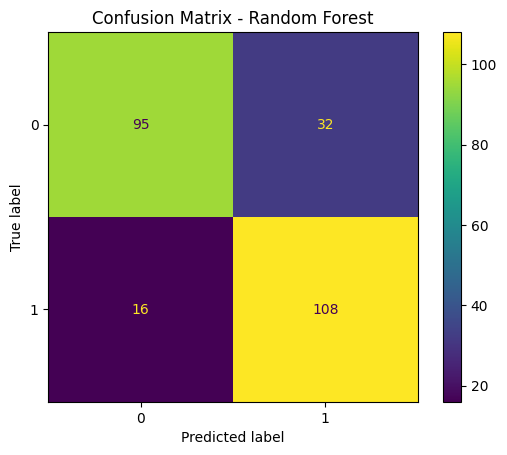

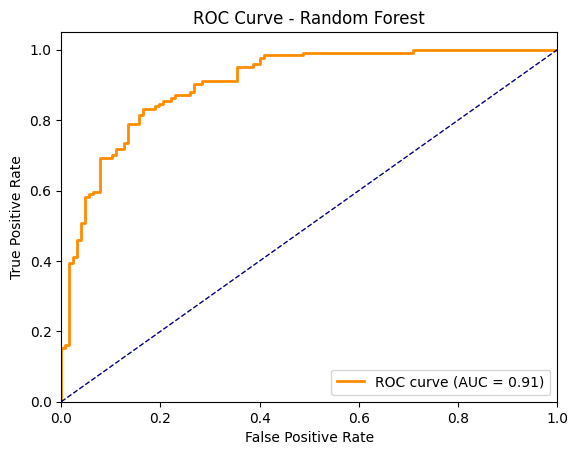

--- XGBClassifier ---
Accuracy: 0.8247
F1 Score: 0.8333



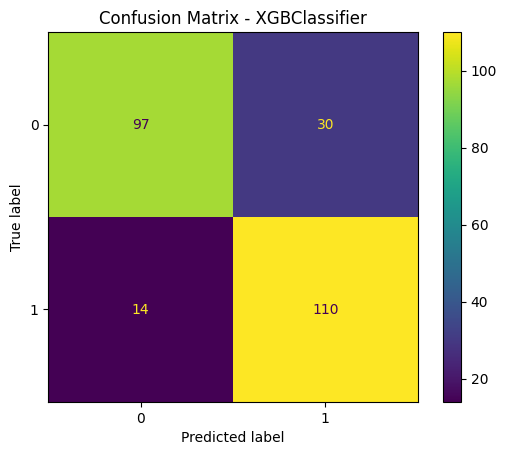

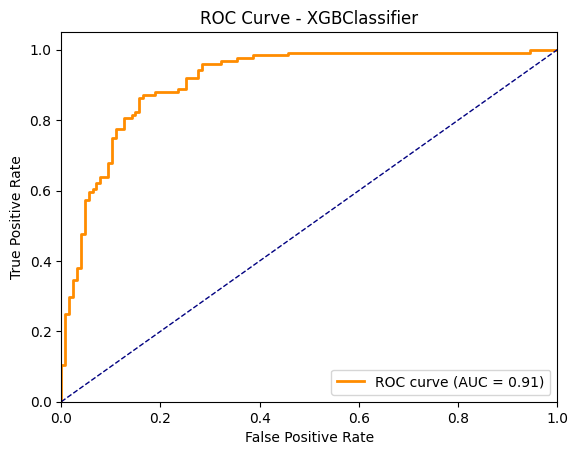

--- Logistic Regression ---
Accuracy: 0.7251
F1 Score: 0.7206



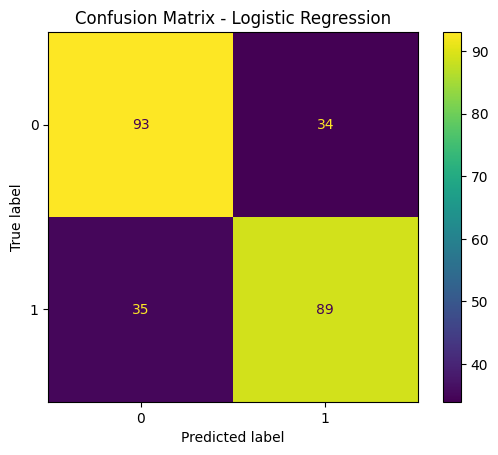

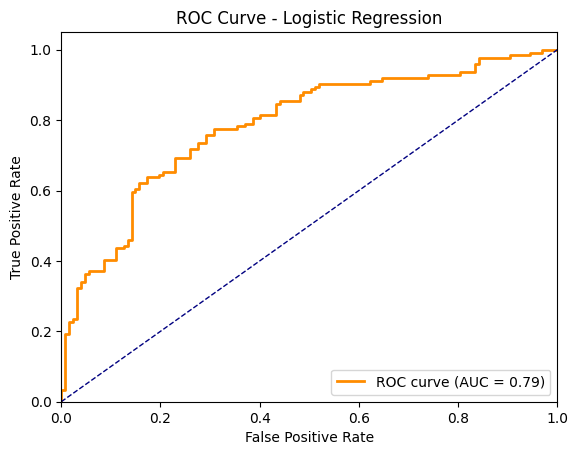

--- KNN ---
Accuracy: 0.7131
F1 Score: 0.6870



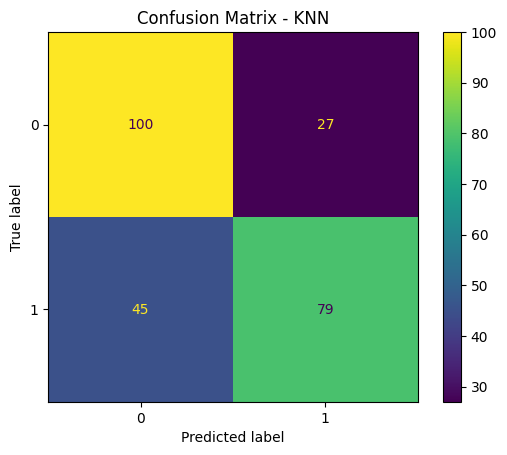

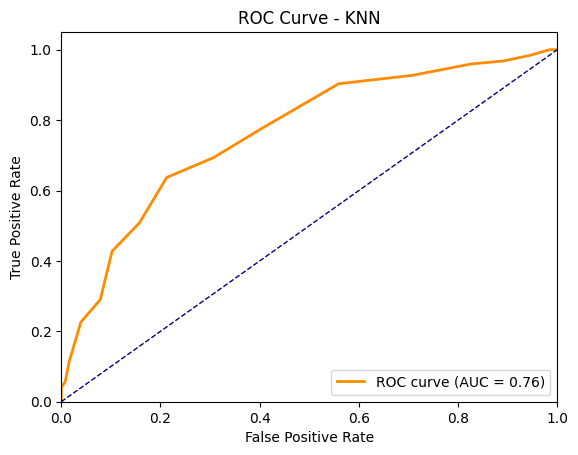

In [47]:
#Trying differnet types of models
models={
    'Random Forest': Pipeline([
        ('model',RandomForestClassifier(n_estimators=100,max_depth=5,
                                        min_samples_split=10,min_samples_leaf=5,
                                        random_state=1))
    ]),
    'XGBClassifier':Pipeline([
        ('model', XGBClassifier(max_depth=3,learning_rate=0.1,
                                n_estimators=100,subsample=0.8,
                                eval_metric='logloss',use_label_encoder=False,
                                random_state=1))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model' , LogisticRegression(max_iter=1000,random_state=1))
    ]),
    'KNN':Pipeline([
        ('scaler',StandardScaler()),
        ('model',KNeighborsClassifier(n_neighbors=20))
    ])
}
accuracies = []
f1_scores=[]
results=[]
for name, pipeline in models.items():
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_valid)
    
    acc= accuracy_score(y_valid,preds)
    accuracies.append(acc)
    f1= f1_score(y_valid, preds)
    f1_scores.append(f1)

    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    cm = confusion_matrix(y_valid,preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    y_probs = pipeline.predict_proba(X_valid)[:, 1]  # Get probabilities for class 1
    fpr, tpr, _ = roc_curve(y_valid, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    plt.show()
    
    # Save metrics
    results.append({
        'Model': name,
        'Val Acc': acc,
        'Val F1': f1
    })

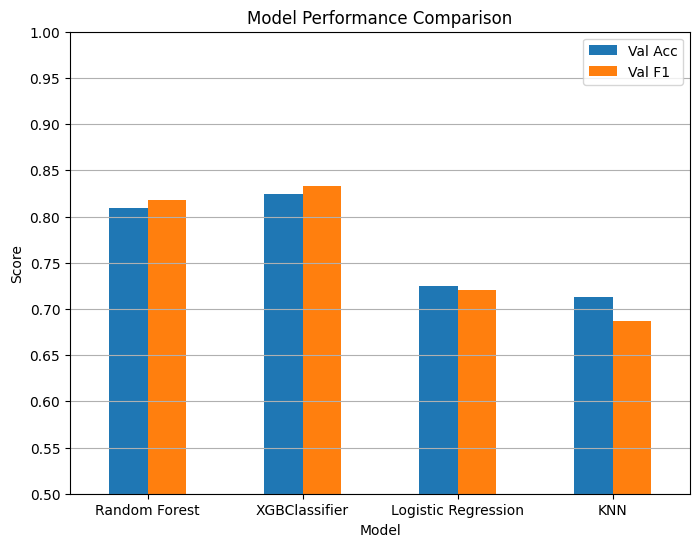

In [39]:
results_df = pd.DataFrame(results)
results_df.plot(x='Model', y=['Val Acc', 'Val F1'], kind='bar', figsize=(8,6))

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


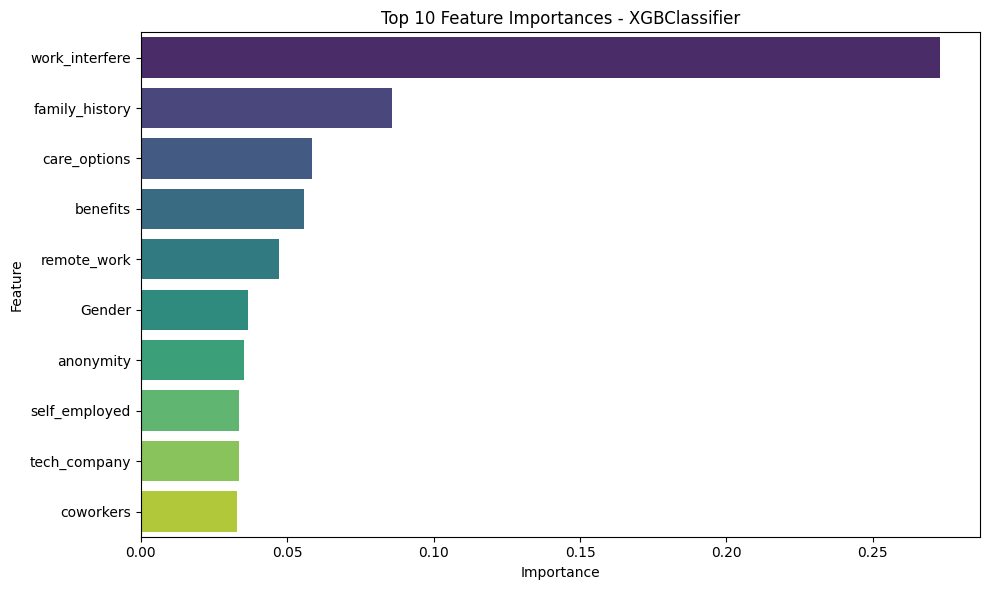

In [42]:
# Feture importance in XGB

xgb = models['XGBClassifier'].named_steps['model']
importances = xgb.feature_importances_
feature_names = X.columns

#sort by features
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = fi_df.sort_values(by='Importance', ascending=False).head(10)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - XGBClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()